# Assignment 4 (ML-II)

# IRIS Dataset (Example 3)

## Wali Ullah (09745)

In [2]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.cluster import AgglomerativeClustering, OPTICS, cluster_optics_dbscan, Birch, MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.mixture import GaussianMixture

In [3]:
# Load Data
def load_data(file_name):
    def readcsv(file_name):
        return pd.read_csv(file_name)
    def readexcel(file_name):
        return pd.read_excel(file_name)
    func_map = {
        "csv": readcsv,
        "xlsx": readexcel,
    }
    
    # default reader = readcsv
    reader = func_map.get("csv")
    
    for k,v in func_map.items():
        if file_name.endswith(k):
            reader = v
            break
    return reader(file_name)

## Data Set

In [4]:
FILE_NAME = "Iris.csv"
#FILE_NAME = "banksim_adj.csv"
#LABEL_COL = "fraud"
df = load_data(FILE_NAME)
display(df.head())
print(df.shape)
print(df.dtypes)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


(150, 5)
sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object


In [5]:
df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
100,6.3,3.3,6.0,2.5,virginica
128,6.4,2.8,5.6,2.1,virginica
31,5.4,3.4,1.5,0.4,setosa
19,5.1,3.8,1.5,0.3,setosa
59,5.2,2.7,3.9,1.4,versicolor


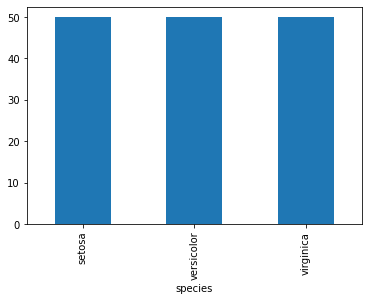

In [6]:
df.groupby('species').size().plot.bar()
plt.show()

In [7]:
X = df.copy()
X = X.drop('species', axis=1)
X.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
# Normalize X

mms = MinMaxScaler()
mms.fit(X)
Xnorm = mms.transform(X)
Xnorm.shape

(150, 4)

# K-Mean Clustering
ELBOW method for finding the optimal # of clusters k

In [9]:
# Not knowing the number of clusters (3) we try a range such 1,10
# For the ELBOW method check with and without init='k-means++'
Sum_of_squared_distances = []
for k in range(1,10):
    km = KMeans(n_clusters=k, init='k-means++')
    km = km.fit(Xnorm)
    Sum_of_squared_distances.append(km.inertia_)

C:\Users\waliullah\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


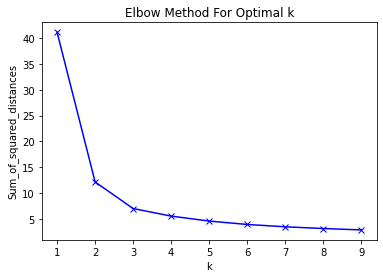

In [10]:
plt.plot(range(1,10), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [11]:
# Knowing from the ELBOW method that k=3 ...
kmeans3 = KMeans(n_clusters=3, init='k-means++').fit(Xnorm) 
KM_clustered = Xnorm.copy()
KM_clustered = pd.DataFrame(KM_clustered)
KM_clustered.loc[:,'Cluster'] = kmeans3.labels_ # append labels to points
frames = [df['species'], KM_clustered['Cluster']]
result = pd.concat(frames, axis = 1)
print(result.shape)
result.sample(5)

(150, 2)


,species,Cluster
118,virginica,2
1,setosa,1
138,virginica,0
37,setosa,1
17,setosa,1


# Assigning a label to each cluster
* As there's no relation between a cluster number and the true label we need to map a cluster to the one label which appears most in that cluster

* These corrected predicted labels are needed below to calculate model performance vs the the true labels

In [12]:
for ClusterNum in range(3):
    OneCluster = pd.DataFrame(result[result['Cluster'] == ClusterNum].groupby('species').size())
    OneCluster.columns=['Size']
    NewDigit = OneCluster.index[OneCluster['Size'] == OneCluster['Size'].max()].tolist()
    NewDigit[0]
    rowIndex = result.index[result['Cluster'] == ClusterNum]
    result.loc[rowIndex, 'TransLabel'] = NewDigit[0]
    print(ClusterNum, NewDigit[0])

0 versicolor
1 setosa
2 virginica


In [13]:
# Check performance of classification to 3 clusters
print('K-Means performance')
print('-'*60)
Correct = (df['species'] == result['TransLabel']).sum()
Accuracy = round(Correct/df.shape[0],3)
print('Accuracy ', Accuracy)
# METRICS for clustering algorithms
print('silhouette: ', round(metrics.silhouette_score(Xnorm, result['TransLabel'],metric='sqeuclidean'),3))
print('homogeneity_score: ', round(metrics.homogeneity_score(df['species'], result['TransLabel']),3))
print('completeness_score: ', round(metrics.completeness_score(df['species'], result['TransLabel']),3))
print('v_measure_score: ', round(metrics.v_measure_score(df['species'], result['TransLabel']),3))
print('adjusted_rand_score: ', round(metrics.adjusted_rand_score(df['species'], result['TransLabel']),3))
print('adjusted_mutual_info_score: ', round(metrics.adjusted_mutual_info_score(df['species'], result['TransLabel']),3))

K-Means performance
------------------------------------------------------------
Accuracy  0.887
silhouette:  0.696
homogeneity_score:  0.736
completeness_score:  0.747
v_measure_score:  0.742
adjusted_rand_score:  0.716
adjusted_mutual_info_score:  0.739


# DBSCAN

In [14]:
# Compute DBSCAN
# played with eps and min samples ... till I got num clustrers = 3 and lowest number of noise (114 ?!?)
db = DBSCAN(eps=0.078).fit(Xnorm)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 114


# Affinity Propagation

In [15]:
af = AffinityPropagation(preference=-3).fit(Xnorm)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)
Clustered = Xnorm.copy()
Clustered = pd.DataFrame(Clustered)
Clustered.loc[:,'Cluster'] = af.labels_ # append labels to points
frames = [df['species'], Clustered['Cluster']]
result = pd.concat(frames, axis = 1)
for ClusterNum in range(3):
    OneCluster = pd.DataFrame(result[result['Cluster'] == ClusterNum].groupby('species').size())
    OneCluster.columns=['Size']
    NewDigit = OneCluster.index[OneCluster['Size'] == OneCluster['Size'].max()].tolist()
    NewDigit[0]
    rowIndex = result.index[result['Cluster'] == ClusterNum]
    result.loc[rowIndex, 'TransLabel'] = NewDigit[0]
    print(ClusterNum, NewDigit[0])

Estimated number of clusters: 3
0 setosa
1 versicolor
2 virginica


C:\Users\waliullah\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [16]:
# Check performance of classification to 3 clusters
print('Affinity propagation performance')
print('-'*60)
Correct = (df['species'] == result['TransLabel']).sum()
Accuracy = round(Correct/df.shape[0],3)
print('Accuracy ', Accuracy)
# METRICS for clustering algorithms
print('silhouette: ', round(metrics.silhouette_score(Xnorm, result['TransLabel'],metric='sqeuclidean'),3))
print('homogeneity_score: ', round(metrics.homogeneity_score(df['species'], result['TransLabel']),3))
print('completeness_score: ', round(metrics.completeness_score(df['species'], result['TransLabel']),3))
print('v_measure_score: ', round(metrics.v_measure_score(df['species'], result['TransLabel']),3))
print('adjusted_rand_score: ', round(metrics.adjusted_rand_score(df['species'], result['TransLabel']),3))
print('adjusted_mutual_info_score: ', round(metrics.adjusted_mutual_info_score(df['species'], result['TransLabel']),3))

Affinity propagation performance
------------------------------------------------------------
Accuracy  0.9
silhouette:  0.696
homogeneity_score:  0.77
completeness_score:  0.786
v_measure_score:  0.778
adjusted_rand_score:  0.745
adjusted_mutual_info_score:  0.775


# Mean Shift

In [17]:
# Compute clustering with MeanShift
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(Xnorm, quantile=0.2) # Manually set the quantile to get num clusters = 3
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(Xnorm)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
Clustered = Xnorm.copy()
Clustered = pd.DataFrame(Clustered)
Clustered.loc[:,'Cluster'] = ms.labels_ # append labels to points
frames = [df['species'], Clustered['Cluster']]
result = pd.concat(frames, axis = 1)

number of estimated clusters : 3


In [18]:
for ClusterNum in range(3):
    OneCluster = pd.DataFrame(result[result['Cluster'] == ClusterNum].groupby('species').size())
    OneCluster.columns=['Size']
    NewDigit = OneCluster.index[OneCluster['Size'] == OneCluster['Size'].max()].tolist()
    NewDigit[0]
    rowIndex = result.index[result['Cluster'] == ClusterNum]
    result.loc[rowIndex, 'TransLabel'] = NewDigit[0] 
    print(ClusterNum, NewDigit[0])

0 versicolor
1 setosa
2 virginica


In [19]:
# Check performance of classification to 3 clusters
print('Mean shift performance')
print('-'*60)
Correct = (df['species'] == result['TransLabel']).sum()
Accuracy = round(Correct/df.shape[0],3)
print('Accuracy ', Accuracy)
# METRICS for clustering algorithms
print('silhouette: ', round(metrics.silhouette_score(Xnorm, result['TransLabel'],metric='sqeuclidean'),3))
print('homogeneity_score: ', round(metrics.homogeneity_score(df['species'], result['TransLabel']),3))
print('completeness_score: ', round(metrics.completeness_score(df['species'], result['TransLabel']),3))
print('v_measure_score: ', round(metrics.v_measure_score(df['species'], result['TransLabel']),3))
print('adjusted_rand_score: ', round(metrics.adjusted_rand_score(df['species'], result['TransLabel']),3))
print('adjusted_mutual_info_score: ', round(metrics.adjusted_mutual_info_score(df['species'], result['TransLabel']),3))

Mean shift performance
------------------------------------------------------------
Accuracy  0.793
silhouette:  0.635
homogeneity_score:  0.673
completeness_score:  0.77
v_measure_score:  0.718
adjusted_rand_score:  0.593
adjusted_mutual_info_score:  0.714


# Spectral Clustering


In [20]:
# Compute clustering with SpectralClustering
sc = SpectralClustering(n_clusters = 3)
sc.fit(Xnorm)
labels = ms.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
Clustered = Xnorm.copy()
Clustered = pd.DataFrame(Clustered)
Clustered.loc[:,'Cluster'] = sc.labels_ # append labels to points
#Clustered.sample(5)
frames = [df['species'], Clustered['Cluster']]
result = pd.concat(frames, axis = 1)
#print(result.shape)
#result.sample(5)
for ClusterNum in range(3):
    OneCluster = pd.DataFrame(result[result['Cluster'] == ClusterNum].groupby('species').size())
    OneCluster.columns=['Size'] 
    NewDigit = OneCluster.index[OneCluster['Size'] == OneCluster['Size'].max()].tolist()
    NewDigit[0]
    rowIndex = result.index[result['Cluster'] == ClusterNum]
    result.loc[rowIndex, 'TransLabel'] = NewDigit[0] 
    print(ClusterNum, NewDigit[0])

number of estimated clusters : 3
0 versicolor
1 setosa
2 virginica


In [21]:
# Check performance of classification to 3 clusters
print('Spectral clustering performance')
print('-'*60)
Correct = (df['species'] == result['TransLabel']).sum()
Accuracy = round(Correct/df.shape[0],3)
print('Accuracy ', Accuracy)
# METRICS for clustering algorithms
print('silhouette: ', round(metrics.silhouette_score(Xnorm, result['TransLabel'],metric='sqeuclidean'),3))
print('homogeneity_score: ', round(metrics.homogeneity_score(df['species'], result['TransLabel']),3))
print('completeness_score: ', round(metrics.completeness_score(df['species'], result['TransLabel']),3))
print('v_measure_score: ', round(metrics.v_measure_score(df['species'], result['TransLabel']),3))
print('adjusted_rand_score: ', round(metrics.adjusted_rand_score(df['species'], result['TransLabel']),3))
print('adjusted_mutual_info_score: ', round(metrics.adjusted_mutual_info_score(df['species'], result['TransLabel']),3))

Spectral clustering performance
------------------------------------------------------------
Accuracy  0.84
silhouette:  0.661
homogeneity_score:  0.651
completeness_score:  0.666
v_measure_score:  0.658
adjusted_rand_score:  0.623
adjusted_mutual_info_score:  0.654


In [22]:
# Agglomerative Clustering
sc = AgglomerativeClustering(n_clusters = 3)
sc.fit(Xnorm)
labels = sc.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
Clustered = Xnorm.copy()
Clustered = pd.DataFrame(Clustered)
Clustered.loc[:,'Cluster'] = sc.labels_ # append labels to points
#Clustered.sample(5)
frames = [df['species'], Clustered['Cluster']]
result = pd.concat(frames, axis = 1)
#print(result.shape)
#result.sample(5)
for ClusterNum in range(3):
    OneCluster = pd.DataFrame(result[result['Cluster'] == ClusterNum].groupby('species').size())
    OneCluster.columns=['Size'] 
    NewDigit = OneCluster.index[OneCluster['Size'] == OneCluster['Size'].max()].tolist()
    NewDigit[0]
    rowIndex = result.index[result['Cluster'] == ClusterNum]
    result.loc[rowIndex, 'TransLabel'] = NewDigit[0]  
    print(ClusterNum, NewDigit[0])

number of estimated clusters : 3
0 versicolor
1 setosa
2 virginica


In [23]:
# Check performance of classification to 3 clusters
print('Agglomerative clustering performance')
print('-'*60)
Correct = (df['species'] == result['TransLabel']).sum()
Accuracy = round(Correct/df.shape[0],3)
print('Accuracy ', Accuracy)
# METRICS for clustering algorithms
print('silhouette: ', round(metrics.silhouette_score(Xnorm, result['TransLabel'],metric='sqeuclidean'),3))
print('homogeneity_score: ', round(metrics.homogeneity_score(df['species'], result['TransLabel']),3))
print('completeness_score: ', round(metrics.completeness_score(df['species'], result['TransLabel']),3))
print('v_measure_score: ', round(metrics.v_measure_score(df['species'], result['TransLabel']),3))
print('adjusted_rand_score: ', round(metrics.adjusted_rand_score(df['species'], result['TransLabel']),3))
print('adjusted_mutual_info_score: ', round(metrics.adjusted_mutual_info_score(df['species'], result['TransLabel']),3))

Agglomerative clustering performance
------------------------------------------------------------
Accuracy  0.887
silhouette:  0.688
homogeneity_score:  0.77
completeness_score:  0.798
v_measure_score:  0.784
adjusted_rand_score:  0.72
adjusted_mutual_info_score:  0.781


# Gaussian Mixture

* Tried w covariance_type='tied' acc = 0.9, 'full' DEFAULT acc = 0.97,  'diag' acc = 0.93,  'spherical' acc = 0.89

In [24]:
# Gaussian Mixture clustering
sc = GaussianMixture(n_components=3, covariance_type='full')
y_pred = sc.fit_predict(Xnorm)
print("number of estimated clusters : %d" % len(set(y_pred)))
Clustered = Xnorm.copy()
Clustered = pd.DataFrame(Clustered)
Clustered.loc[:,'Cluster'] = y_pred # append labels to points
#Clustered.sample(5)
frames = [df['species'], Clustered['Cluster']]
result = pd.concat(frames, axis = 1)
#print(result.shape)
#result.sample(5)
for ClusterNum in range(3):
    OneCluster = pd.DataFrame(result[result['Cluster'] == ClusterNum].groupby('species').size())
    OneCluster.columns=['Size'] 
    NewDigit = OneCluster.index[OneCluster['Size'] == OneCluster['Size'].max()].tolist()
    NewDigit[0]
    rowIndex = result.index[result['Cluster'] == ClusterNum]
    result.loc[rowIndex, 'TransLabel'] = NewDigit[0] 
    print(ClusterNum, NewDigit[0])

number of estimated clusters : 3
0 virginica
1 versicolor
2 setosa


In [25]:
# Check performance of classification to 3 clusters
print('Gaussian mixture clustering performance')
print('-'*60)
Correct = (df['species'] == result['TransLabel']).sum()
Accuracy = round(Correct/df.shape[0],3)
print('Accuracy ', Accuracy)
# METRICS for clustering algorithms
print('silhouette: ', round(metrics.silhouette_score(Xnorm, result['TransLabel'],metric='sqeuclidean'),3))
print('homogeneity_score: ', round(metrics.homogeneity_score(df['species'], result['TransLabel']),3))
print('completeness_score: ', round(metrics.completeness_score(df['species'], result['TransLabel']),3))
print('v_measure_score: ', round(metrics.v_measure_score(df['species'], result['TransLabel']),3))
print('adjusted_rand_score: ', round(metrics.adjusted_rand_score(df['species'], result['TransLabel']),3))
print('adjusted_mutual_info_score: ', round(metrics.adjusted_mutual_info_score(df['species'], result['TransLabel']),3))

Gaussian mixture clustering performance
------------------------------------------------------------
Accuracy  0.967
silhouette:  0.606
homogeneity_score:  0.898
completeness_score:  0.901
v_measure_score:  0.9
adjusted_rand_score:  0.904
adjusted_mutual_info_score:  0.898


# BIRCH Clustering

In [26]:
sc = Birch(n_clusters = 3)
sc.fit(Xnorm)
labels = sc.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 2


C:\Users\waliullah\Anaconda3\lib\site-packages\sklearn\cluster\_birch.py:647: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(


# Mini Batch K-Means

In [27]:
# Mini Batch K-Means Clustering
sc = MiniBatchKMeans(n_clusters = 3)
sc.fit(Xnorm)
labels = sc.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
Clustered = Xnorm.copy()
Clustered = pd.DataFrame(Clustered)
Clustered.loc[:,'Cluster'] = sc.labels_ # append labels to points
#Clustered.sample(5)
frames = [df['species'], Clustered['Cluster']]
result = pd.concat(frames, axis = 1)
#print(result.shape)
#result.sample(5)
for ClusterNum in range(3):
    OneCluster = pd.DataFrame(result[result['Cluster'] == ClusterNum].groupby('species').size())
    OneCluster.columns=['Size'] 
    NewDigit = OneCluster.index[OneCluster['Size'] == OneCluster['Size'].max()].tolist()
    NewDigit[0]
    rowIndex = result.index[result['Cluster'] == ClusterNum]
    result.loc[rowIndex, 'TransLabel'] = NewDigit[0]
    print(ClusterNum, NewDigit[0])

number of estimated clusters : 3
0 versicolor
1 setosa
2 virginica


C:\Users\waliullah\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [28]:
# Check performance of classification to 3 clusters
print('Mini Batch K-Means clustering performance')
print('-'*60)
Correct = (df['species'] == result['TransLabel']).sum()
Accuracy = round(Correct/df.shape[0],3)
print('Accuracy ', Accuracy)
# METRICS for clustering algorithms
print('silhouette: ', round(metrics.silhouette_score(Xnorm, result['TransLabel'],metric='sqeuclidean'),3))
print('homogeneity_score: ', round(metrics.homogeneity_score(df['species'], result['TransLabel']),3))
print('completeness_score: ', round(metrics.completeness_score(df['species'], result['TransLabel']),3))
print('v_measure_score: ', round(metrics.v_measure_score(df['species'], result['TransLabel']),3))
print('adjusted_rand_score: ', round(metrics.adjusted_rand_score(df['species'], result['TransLabel']),3))
print('adjusted_mutual_info_score: ', round(metrics.adjusted_mutual_info_score(df['species'], result['TransLabel']),3))

Mini Batch K-Means clustering performance
------------------------------------------------------------
Accuracy  0.893
silhouette:  0.662
homogeneity_score:  0.735
completeness_score:  0.736
v_measure_score:  0.736
adjusted_rand_score:  0.728
adjusted_mutual_info_score:  0.732


# Hierarchial Clustering

In [29]:
iris = pd.read_csv("Iris.csv") 
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [30]:
iris.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [31]:
iris_SP = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
iris_SP.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [32]:
iris_SP.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


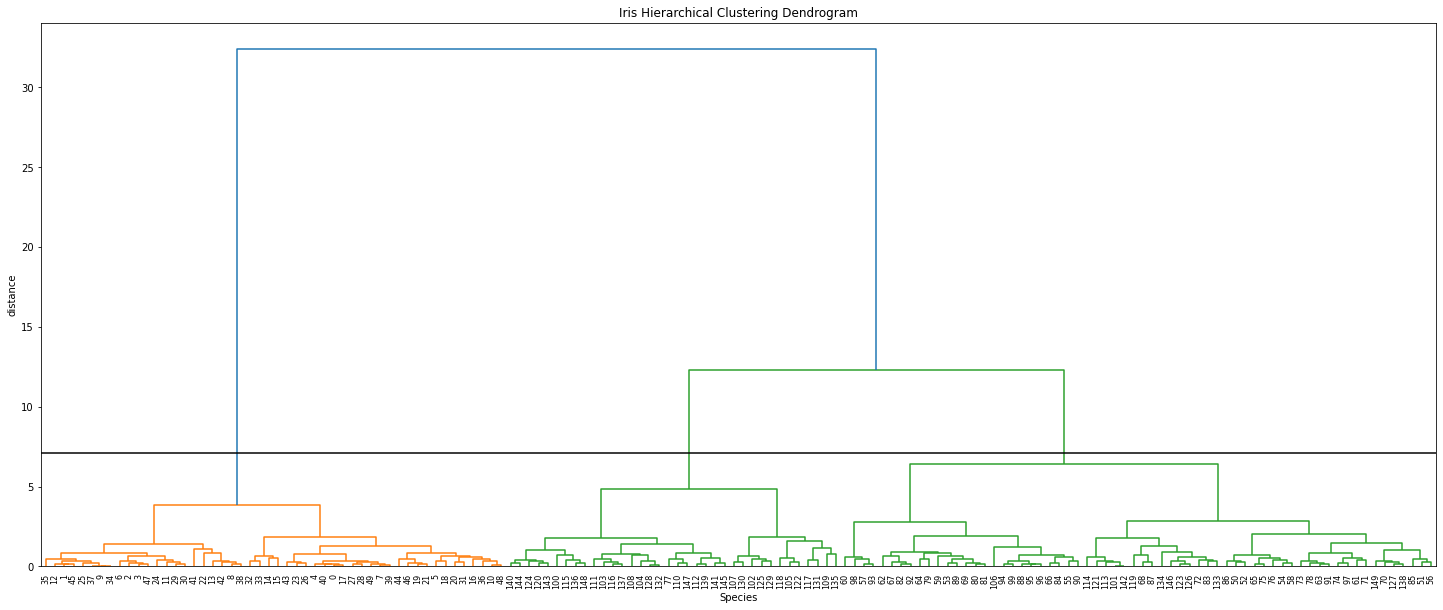

In [33]:
# calculate full dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
# generate the linkage matrix
Z = linkage(iris_SP, 'ward')
# set cut-off to 150
max_d = 7.08                # max_d as in max_distance
plt.figure(figsize=(25, 10))
plt.title('Iris Hierarchical Clustering Dendrogram')
plt.xlabel('Species')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=150,                  # Try changing values of p
    leaf_rotation=90.,      # rotates the x axis labels
    leaf_font_size=8.,      # font size for the x axis labels
)
plt.axhline(y=max_d, c='k')
plt.show()

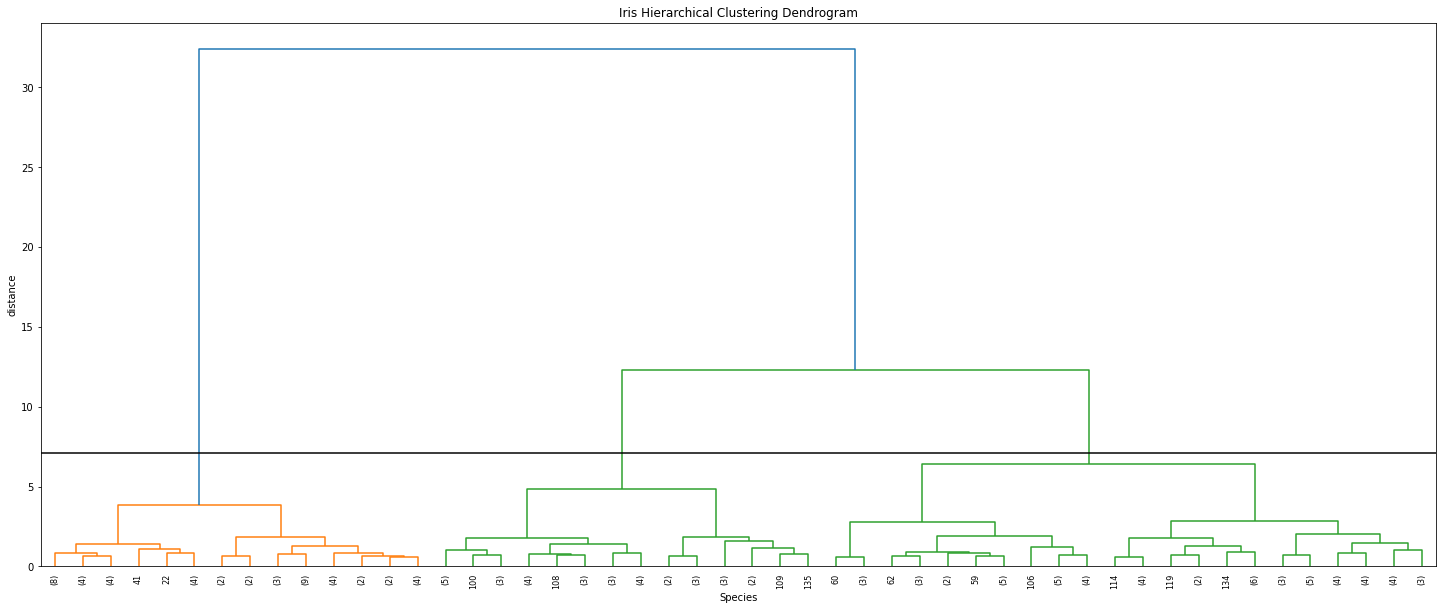

In [34]:
# calculate full dendrogram for 50
from scipy.cluster.hierarchy import dendrogram, linkage
# generate the linkage matrix
Z = linkage(iris_SP, 'ward')
# set cut-off to 50
max_d = 7.08                # max_d as in max_distance
plt.figure(figsize=(25, 10))
plt.title('Iris Hierarchical Clustering Dendrogram')
plt.xlabel('Species')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,                  # Try changing values of p
    leaf_rotation=90.,      # rotates the x axis labels
    leaf_font_size=8.,      # font size for the x axis labels
)
plt.axhline(y=max_d, c='k')
plt.show()

### CONCLUSION

Even when working on the same dataset, the results obtained from using different hierarchical clustering algorithms can vary a lot. Wich algorithm to use seems to depend on how evident is the grouping criteria between the variables.

k-Means and Mini Batch k-Means accuracy: 0.89 ... silhouette: 0.696

DBSCAN and Optics accuracy: with 3 clusters there are 114 outliers with DBSCAN and similar w OPTICS (?!)

Affinity Propagation accuracy: 0.90 ... silhouette: 0.696

Mean Shift accuracy: 0.79 ... silhouette: 0.635

Spectral Clustering accuracy: 0.84 ... silhouette: 0.661

Agglomerative Clustering accuracy: 0.89 ... silhouette: 0.688

Gaussian Mixture Clustering accuracy: 0.97 ... silhouette: 0.606

Birch finds only 2 clusters